## Titanic Survival Prediction



### Import Libraries and Data

In [1]:
import os, sys
import numpy as np # Linear Algebra
import pandas as pd # Data Handling and Manipulation
import seaborn as sb # Data Visualization
import matplotlib.pyplot as plt # Data Visualization

from sklearn import metrics
from sklearn.svm import SVC # Support Vector Classifier
from xgboost import XGBClassifier # XGB Classifier
from sklearn.tree import DecisionTreeClassifier # Decision Tree Classifier
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.ensemble import RandomForestClassifier # Random Forest Classifier
from sklearn.model_selection import train_test_split # Splitting Training and Test data sets from Train Data


### Load Database

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
print(train_data.info())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(test_data.info())
test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Combine Train and Test

In [5]:
combine = [train_data, test_data]

### Check Missing Values

In [6]:
for data in combine:
    print()
    for c in data.columns:
        missing = 100 * data[c].isnull().sum() / len(data[c])
        if missing :
            print(c, missing, '%')


Age 19.865319865319865 %
Cabin 77.10437710437711 %
Embarked 0.2244668911335578 %

Age 20.574162679425836 %
Fare 0.23923444976076555 %
Cabin 78.22966507177034 %


### Fill in the missing values

We can see from the above that three columns in each dataset have null values in varying percentages.

In the training dataset the columns `Age`, `Cabin` and `Embarked` and in the test dataset the columns `Age`, `Fare` and `Cabin` contain some null values.

Before we begin to analyze any of the datasets, we need to get them rid of the null values with somewhat more meaningful values.

For e.g. The null values in the `Age` and `Fare` columns should be replaced by their respective mean values.

In [7]:
train_data.Age = train_data.Age.fillna(train_data.Age.mean())
test_data.Age = test_data.Age.fillna(test_data.Age.mean())
test_data.Fare = test_data.Fare.fillna(test_data.Fare.mean())

print("Train Dataset : missing values in 'Age' :", (100 * train_data.Age.isnull().sum() / len(train_data.Age)), '%')
print("Test Dataset : missing values in 'Age' :", (100 * test_data.Age.isnull().sum() / len(test_data.Age)), '%')
print("Test Dataset : missing values in 'Fare' :", (100 * test_data.Fare.isnull().sum() / len(test_data.Fare)), '%')

Train Dataset : missing values in 'Age' : 0.0 %
Test Dataset : missing values in 'Age' : 0.0 %
Test Dataset : missing values in 'Fare' : 0.0 %


Thus, all the missing values have now been substituted with more meaningful alternatives.

And the columns `Cabin` and `Embarked` in the datasets are not treated as they are not useful for predicting a person's chances for survival, the reason for which we will later take a brief glance at.

### Feature Dependencies

In [8]:
print(train_data.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


Let us look at the dependencies of the column `Survived` with respect to other columns, `Pclasss`, `Sex`, `SibSp`, `Parch`.

In [9]:
dependency_Pclass = train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()
dependency_Sex = train_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()
dependency_SibSp = train_data[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean()
dependency_Parch = train_data[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean()

print(dependency_Pclass, '\n')
print(dependency_Sex, '\n')
print(dependency_SibSp, '\n')
print(dependency_Parch, '\n')

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363 

      Sex  Survived
0  female  0.742038
1    male  0.188908 

   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000 

   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000 



You can look at the strong dependency of a person's chance of survival and the parameters pointed out.

### Visual verification of feature selection

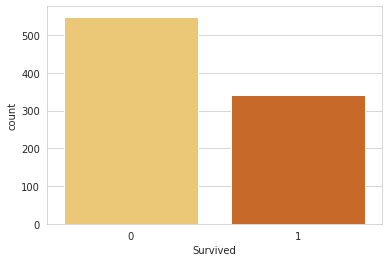

In [10]:
sb.set_style('whitegrid')
sb.countplot(x='Survived', data=train_data, palette='YlOrBr')

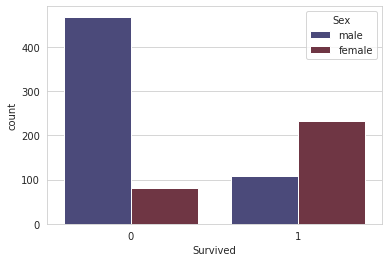

In [11]:
sb.set_style('whitegrid')
sb.countplot(x='Survived', hue='Sex', data=train_data, palette="icefire")

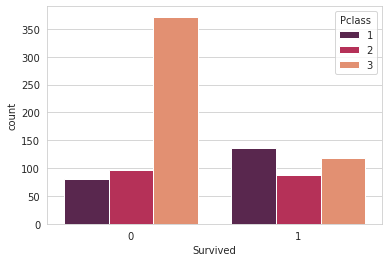

In [12]:
sb.set_style('whitegrid')
sb.countplot(x='Survived', hue='Pclass', data=train_data, palette="rocket")

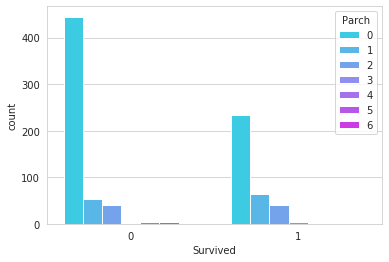

In [13]:
sb.set_style('whitegrid')
sb.countplot(x='Survived', hue="Parch", data=train_data, palette="cool")

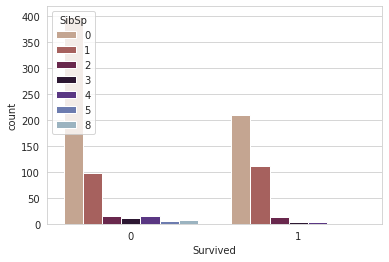

In [14]:
sb.set_style('whitegrid')
sb.countplot(x='Survived', hue='SibSp', data=train_data, palette="twilight_r")

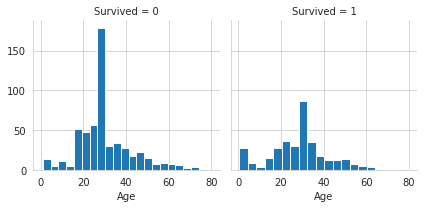

In [15]:
g = sb.FacetGrid(train_data, col="Survived")
g.map(plt.hist, 'Age', bins=20)

### Some Feature Engineering

In [16]:
for data in combine:
    data['Title'] = data.Name.str.extract('([A-Za-z]+)\.',expand=False)
    print(data.Title.unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


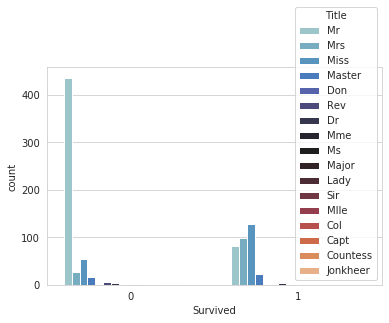

In [17]:
sb.set_style('whitegrid')
sb.countplot(x='Survived', hue='Title', data=train_data, palette='icefire')

In [18]:
for data in combine:
    data.Title = data.Title.replace(['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 'Dona', 'Countess', 'Jonkheer'], 'Rare')
    data.Title = data.Title.replace('Mme', 'Mrs')
    data.Title = data.Title.replace(['Mlle', 'Ms'], 'Mrs')
    print(data.Title.unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Rare']
['Mr' 'Mrs' 'Miss' 'Master' 'Rare']


In [19]:
title_mapping = {'Mr' : 1, 'Mrs' : 3, 'Miss' : 2, 'Master' : 4, 'Rare' : 5}
for data in combine:
    data.Title = data.Title.map(title_mapping)
    data.Title = data.Title.fillna(0)
    print(data.Title.unique())

[1 3 2 4 5]
[1 3 2 4 5]


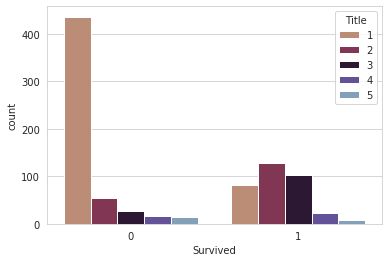

In [20]:
sb.set_style('whitegrid')
sb.countplot(x='Survived', hue='Title', data=train_data, palette="twilight_r")

In [21]:
for data in combine:
    data.Sex = data.Sex.map({'male' : 0, 'female' : 1})
    print(data.Sex.unique())

[0 1]
[0 1]


### Finalize Features

In [22]:
train = train_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
test = test_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)

combine = [train, test]

### Split Training Data

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(train.drop(['Survived'], axis=1), train_data.Survived, test_size=0.1, random_state=None)

print(X_train.info(), Y_train.describe())
print(X_test.info(), Y_test.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 801 entries, 98 to 798
Data columns (total 7 columns):
Pclass    801 non-null int64
Sex       801 non-null int64
Age       801 non-null float64
SibSp     801 non-null int64
Parch     801 non-null int64
Fare      801 non-null float64
Title     801 non-null int64
dtypes: float64(2), int64(5)
memory usage: 50.1 KB
None count    801.000000
mean       0.385768
std        0.487080
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 665 to 219
Data columns (total 7 columns):
Pclass    90 non-null int64
Sex       90 non-null int64
Age       90 non-null float64
SibSp     90 non-null int64
Parch     90 non-null int64
Fare      90 non-null float64
Title     90 non-null int64
dtypes: float64(2), int64(5)
memory usage: 5.6 KB
None count    90.000000
mean      0.366667
std       0.484594
min       0.000000
25%  

### Logistic Regression

In [24]:
modelLogisticRegression = LogisticRegression()
modelLogisticRegression.fit(X_train, Y_train)


LogisticRegression()

In [25]:
predictionLogisticRegression = modelLogisticRegression.predict(X_test)
scoreLogisticRegression = metrics.accuracy_score(Y_test, predictionLogisticRegression)

print(predictionLogisticRegression)
print("The accuracy of Logistic Regression model is ", scoreLogisticRegression * 100)

[0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0]
The accuracy of Logistic Regression model is  80.0


### Decision Tree

In [26]:
modelDecisionTree = DecisionTreeClassifier()
modelDecisionTree.fit(X_train, Y_train)

DecisionTreeClassifier()

In [27]:
predictionDecisionTree = modelDecisionTree.predict(X_test)
scoreDecisionTree = metrics.accuracy_score(Y_test, predictionDecisionTree)

print(predictionDecisionTree)
print("The accuracy of Decision Tree", scoreDecisionTree * 100)

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0]
The accuracy of Decision Tree 77.77777777777779


### Random Forest

In [28]:
modelRandomForest = RandomForestClassifier()
modelRandomForest.fit(X_train, Y_train)

RandomForestClassifier()

In [29]:
predictionRandomForest = modelRandomForest.predict(X_test)
scoreRandomForest = metrics.accuracy_score(Y_test, predictionRandomForest)

print(predictionDecisionTree)
print("The accuracy of Random Forest Classifier is : ", scoreRandomForest * 100, "%")

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0]
The accuracy of Random Forest Classifier is :  86.66666666666667 %


### SVC

In [30]:
modelSVC = SVC()
modelSVC.fit(X_train, Y_train)

SVC()

In [31]:
predictionSVC = modelSVC.predict(X_test)
scoreSVC = metrics.accuracy_score(Y_test, predictionSVC)

print(predictionSVC)
print("The accuracy of SVC Classifier is : ", scoreSVC * 100, "%")

[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
The accuracy of SVC Classifier is :  62.22222222222222 %


### Gradient Boosting

In [32]:
modelXGB = XGBClassifier()
modelXGB.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
predictionXGB = modelXGB.predict(X_test)
scoreXGB = metrics.accuracy_score(Y_test, predictionXGB)

print(predictionXGB)
print("The accuracy of XGB Classifier is :", scoreXGB * 100, "%")

[1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
The accuracy of XGB Classifier is : 82.22222222222221 %


### Artificial Neural Networks

In [34]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import classification_report

In [41]:
nn  = Sequential()
nn.add(Dense(units= 32, activation = 'relu', input_dim=7, kernel_initializer="uniform"))
nn.add(Dense(units= 32, activation = 'relu',kernel_initializer="uniform"))
nn.add(Dense(units= 32, activation = 'relu',kernel_initializer="uniform"))
nn.add(Dense(units= 32, activation = 'relu',kernel_initializer="uniform"))
nn.add(Dense(units= 1, activation = 'sigmoid',kernel_initializer="uniform"))
nn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [47]:
nn.fit(X_train,Y_train, batch_size=32,epochs=1500,verbose= 0)

nn_pred = nn.predict(X_test)
nn_pred = [ 1 if y>=0.5 else 0 for y in nn_pred]
print(nn_pred)

acc_NN = metrics.accuracy_score(Y_test, nn_pred)

print("We can see that the neural network gives an Accuracy of ", acc_NN*100 , "%")

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
We can see that the neural network gives an Accuracy of  86.66666666666667 %


### Choose the best model

### Predict